In [ ]:
!pip install tqdm

In [ ]:
import os
import random
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook

import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np

import torch
import torchvision
import torchsummary
from torch.utils import data
from torchvision import datasets, models, transforms

SEED = 42
np.random.seed(SEED)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

if str(device) == "cuda:0":
  print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda:0
GPU: Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip -O EuroSAT.zip
!unzip -q EuroSAT.zip -d 'EuroSAT/'
!rm EuroSAT.zip

--2024-11-02 15:07:26--  http://madm.dfki.de/files/sentinel/EuroSAT.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94280567 (90M) [application/zip]
Saving to: ‘EuroSAT.zip’

EuroSAT.zip         100%[===================>]  89.91M  18.4MB/s    in 6.1s    

2024-11-02 15:07:33 (14.8 MB/s) - ‘EuroSAT.zip’ saved [94280567/94280567]



In [ ]:
class EuroSAT(data.Dataset):
  def __init__(self, dataset, transform=None):
    self.dataset = dataset
    self.transform = transform

  def __getitem__(self, index):
    if self.transform:
      x = self.transform(self.dataset[index][0])
    else:
      x = self.dataset[index][0]
    y = self.dataset[index][1]
    return x, y

  def __len__(self):
      return len(dataset)

In [ ]:
input_size = 224
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

In [ ]:
data_dir = './EuroSAT/2750/'
dataset = datasets.ImageFolder(data_dir)

class_names = dataset.classes
print(f"Class names: {class_names}")
print(f"Total number of classes: {len(class_names)}")

Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Total number of classes: 10


In [ ]:
train_data = EuroSAT(dataset, train_transform)
val_data = EuroSAT(dataset, val_transform)
test_data = EuroSAT(dataset, test_transform)

train_size = 0.70
val_size = 0.15
indices = list(range(int(len(dataset))))
train_split = int(train_size * len(dataset))
val_split = int(val_size * len(dataset))
np.random.shuffle(indices)

train_data = data.Subset(train_data, indices=indices[:train_split])
val_data = data.Subset(val_data, indices=indices[train_split: train_split+val_split])
test_data = data.Subset(test_data, indices=indices[train_split+val_split:])
print("Train/val/test sizes: {}/{}/{}".format(len(train_data), len(val_data), len(test_data)))

Train/val/test sizes: 18900/4050/4050


In [ ]:
num_workers = 2
batch_size = 16

train_loader = data.DataLoader(
    train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True
)
val_loader = data.DataLoader(
    val_data, batch_size=batch_size, num_workers=num_workers, shuffle=False
)
test_loader = data.DataLoader(
    test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False
)

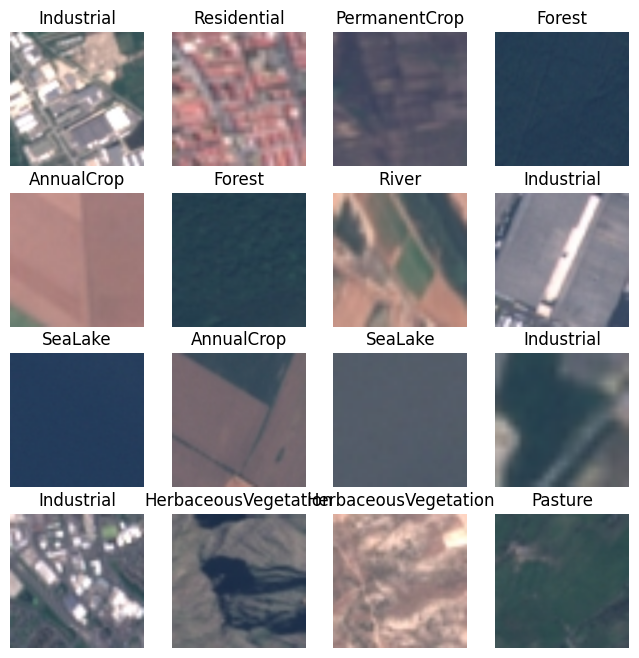

In [ ]:
n = 4
inputs, classes = next(iter(train_loader))
fig, axes = plt.subplots(n, n, figsize=(8, 8))

for i in range(n):
  for j in range(n):
    image = inputs[i * n + j].numpy().transpose((1, 2, 0))
    image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

    title = class_names[classes[i * n + j]]
    axes[i, j].imshow(image)
    axes[i, j].set_title(title)
    axes[i, j].axis('off')

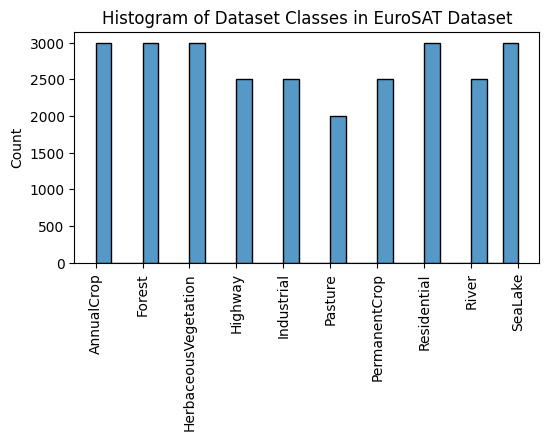

In [ ]:
plt.figure(figsize=(6, 3))
hist = sns.histplot(dataset.targets)

hist.set_xticks(range(len(dataset.classes)))
hist.set_xticklabels(dataset.classes, rotation=90)
hist.set_title('Histogram of Dataset Classes in EuroSAT Dataset')

plt.show()

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = torch.nn.Linear(model.fc.in_features, len(dataset.classes))
model = model.to(device)
torchsummary.summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
n_epochs = 10
lr = 1e-3

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [ ]:
def train(model, dataloader, criterion, optimizer):
  model.train()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = model(inputs)

    loss = criterion(outputs, labels)

    loss.backward()

    optimizer.step()

    _, preds = torch.max(outputs, 1)

    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print(f"Train Loss: {epoch_loss:.2f}; Accuracy: {epoch_accuracy:.2f}")

  return epoch_loss, epoch_accuracy

In [ ]:
def evaluate(model, dataloader, criterion, phase="val"):
  model.eval()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs, 1)

    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print(f"{phase.title()} Loss: {epoch_loss:.2f}; Accuracy: {epoch_accuracy:.2f}")

  return epoch_loss, epoch_accuracy

In [ ]:
def fit(model, train_loader, val_loader, n_epochs, lr, criterion, optimizer):
  best_loss = np.inf
  best_model = None

  for epoch in range(n_epochs):
    print("Epoch {}".format(epoch+1))
    train(model, train_loader, criterion, optimizer)
    val_loss, _ = evaluate(model, val_loader, criterion)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model = model

  return best_model

In [ ]:
best_model = fit(model, train_loader, val_loader, n_epochs, lr, criterion, optimizer)

Epoch 1


100%|██████████| 1182/1182 [03:11<00:00,  6.18it/s]


Train Loss: 1.67; Accuracy: 51.88


100%|██████████| 254/254 [00:16<00:00, 15.60it/s]


Val Loss: 1.13; Accuracy: 73.68
Epoch 2


100%|██████████| 1182/1182 [03:16<00:00,  6.03it/s]


Train Loss: 0.93; Accuracy: 71.90


100%|██████████| 254/254 [00:16<00:00, 15.18it/s]


Val Loss: 0.59; Accuracy: 84.30
Epoch 3


100%|██████████| 1182/1182 [03:12<00:00,  6.14it/s]


Train Loss: 0.70; Accuracy: 77.54


100%|██████████| 254/254 [00:16<00:00, 15.68it/s]


Val Loss: 0.42; Accuracy: 87.70
Epoch 4


100%|██████████| 1182/1182 [03:12<00:00,  6.14it/s]


Train Loss: 0.59; Accuracy: 80.42


100%|██████████| 254/254 [00:15<00:00, 16.80it/s]


Val Loss: 0.35; Accuracy: 89.90
Epoch 5


100%|██████████| 1182/1182 [03:12<00:00,  6.14it/s]


Train Loss: 0.53; Accuracy: 82.57


100%|██████████| 254/254 [00:14<00:00, 16.98it/s]


Val Loss: 0.29; Accuracy: 91.70
Epoch 6


100%|██████████| 1182/1182 [03:12<00:00,  6.14it/s]


Train Loss: 0.47; Accuracy: 84.68


100%|██████████| 254/254 [00:15<00:00, 16.60it/s]


Val Loss: 0.22; Accuracy: 93.36
Epoch 7


100%|██████████| 1182/1182 [03:12<00:00,  6.14it/s]


Train Loss: 0.44; Accuracy: 85.82


100%|██████████| 254/254 [00:14<00:00, 17.02it/s]


Val Loss: 0.20; Accuracy: 94.35
Epoch 8


100%|██████████| 1182/1182 [03:12<00:00,  6.14it/s]


Train Loss: 0.41; Accuracy: 86.60


100%|██████████| 254/254 [00:15<00:00, 16.77it/s]


Val Loss: 0.19; Accuracy: 94.64
Epoch 9


100%|██████████| 1182/1182 [03:12<00:00,  6.15it/s]


Train Loss: 0.38; Accuracy: 87.58


100%|██████████| 254/254 [00:15<00:00, 16.72it/s]


Val Loss: 0.15; Accuracy: 95.09
Epoch 10


100%|██████████| 1182/1182 [03:12<00:00,  6.15it/s]


Train Loss: 0.37; Accuracy: 88.03


100%|██████████| 254/254 [00:14<00:00, 17.16it/s]

Val Loss: 0.14; Accuracy: 95.53


In [ ]:
test_loss, _ = evaluate(best_model, test_loader, criterion, phase="test")

100%|██████████| 254/254 [00:15<00:00, 16.87it/s]

Test Loss: 0.14; Accuracy: 96.02


In [ ]:
model_dir = "./drive/My Drive/Colab Notebooks/models/"
if not os.path.exists(model_dir):
  os.makedirs(model_dir)

model_file = os.path.join(model_dir, 'best_model.pth')
model_file

'./drive/My Drive/Colab Notebooks/models/best_model.pth'

In [ ]:
def save_model(best_model, model_file):
  torch.save(best_model.state_dict(), model_file)
  print('Model successfully saved to {}.'.format(model_file))

In [ ]:
save_model(best_model, model_file)

Model successfully saved to ./drive/My Drive/Colab Notebooks/models/best_model.pth.
